# Importing Libraries to be used 

In [765]:
import pandas as pd # for data manipulation
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt # for data visualization

# Load 3 SMS/call/internet activity data

In [766]:
df_2013_11_02 = pd.read_csv("data/sms-call-internet-mi-2013-11-02.csv")
df_2013_11_04 = pd.read_csv("data/sms-call-internet-mi-2013-11-04.csv")
df_2013_11_06 = pd.read_csv("data/sms-call-internet-mi-2013-11-06.csv")

# Converting the datetime column into a proper datetime format to enable time-based analysis.

In [767]:
df_2013_11_02["datetime"] = pd.to_datetime(df_2013_11_02['datetime'])
df_2013_11_04["datetime"] = pd.to_datetime(df_2013_11_04['datetime'])
df_2013_11_06["datetime"] = pd.to_datetime(df_2013_11_06['datetime'])

# Extracting and adding date and hour(time) columns to each dataframe

for df in [df_2013_11_02, df_2013_11_04, df_2013_11_06]:
    df['date'] = df['datetime'].dt.date
    df['hour'] = df['datetime'].dt.hour

# Combining all the dataframes into one

In [768]:

# Combining all dataframes into one
combined_df = pd.concat([df_2013_11_02, df_2013_11_04, df_2013_11_06], ignore_index=True)


## Q4 Are there any missing values ?

In [769]:
# checking Missing values before filling 
missing_values = combined_df.isna().sum()
print("Missing values before filling:\n", missing_values)

Missing values before filling:
 datetime             0
CellID               0
countrycode          0
smsin          3964171
smsout         5025738
callin         4761685
callout        3764484
internet       3621117
date                 0
hour                 0
dtype: int64


#####  Yes, the dataset contains missing values.
##### Missing values are present in the activity-related columns such as smsin, smsout, callin, callout, and internet, reflecting periods with no recorded activity for certain grid–country combinations.

   ## Q4.2 For which columns are missing values most common?

In [770]:
# Activity/numeric columns where missing values  occur
numeric_cols = ["smsin", "smsout", "callin", "callout", "internet"]

# Count missing values for each activity/Numeric column
missing_values_by_column = (
    combined_df[numeric_cols]
    .isna()
    .sum()
    .reset_index()
)

# Renaming columns to make the table readable
missing_values_by_column.columns = ["Column", "Missing_Values"]

# Sorting the table in ascending order
missing_values_by_column_sorted = missing_values_by_column.sort_values(
    by="Missing_Values",
    ascending=True
)

# Displaying the sorted table
missing_values_by_column_sorted


,Column,Missing_Values
4,internet,3621117
3,callout,3764484
0,smsin,3964171
2,callin,4761685
1,smsout,5025738


In [771]:
# Extracting the column with the maximum number of missing values
most_missing_column = missing_values_by_column_sorted.iloc[-1]["Column"]
most_missing_count = missing_values_by_column_sorted.iloc[-1]["Missing_Values"]

print("Column with the most missing values:", most_missing_column)
print("Number of missing values:", f"{most_missing_count :,}")  


Column with the most missing values: smsout
Number of missing values: 5,025,738


##### After ordering the activity columns by the number of missing values, smsout has the highest number of missing values, followed by callin, smsin, callout, and internet. This ordering indicates that outgoing SMS activity is the most sparsely recorded, while call-related activities also exhibit substantial sparsity. The pattern reflects the presence of many grid–country combinations, particularly involving international users and low-activity areas, where outgoing communications occur less frequently or are not recorded.

In [772]:

rows_with_nan = combined_df[numeric_cols].isna().any(axis=1)
num_rows_to_modify = rows_with_nan.sum()
print("Number of rows To be modified:", f"{num_rows_to_modify :,}")

Number of rows To be modified: 5,880,441


## Q4.1 Handling missing values (NaN) , filling them with mean 

In [773]:
for col in numeric_cols:
    mean_value = combined_df[col].mean()
    combined_df[col]= combined_df[col].fillna(mean_value)

### Verifying that there are no missing values in the combined dataframe

In [774]:
combined_df[numeric_cols].isna().sum()


smsin       0
smsout      0
callin      0
callout     0
internet    0
dtype: int64

### From the output above Missing values in activity columns were imputed using the mean of each respective column to enable aggregate analysis.

## Q4.3 How many records did you modify?

### Records to be modified were identified prior to imputation as rows containing at least one missing value. After mean imputation, these records were verified to contain no missing values.

In [775]:
modified_records = num_rows_to_modify
print("Number of records modified:", f"{modified_records :,}")

Number of records modified: 5,880,441


# Adding aggreaget columns 

In [776]:
# total_sms = smsin + smsout
# total_calls = callin + callout
# total_internet = internet
combined_df['total_sms'] = combined_df['smsin'] + combined_df['smsout']
combined_df['total_calls'] = combined_df['callin'] + combined_df['callout']
combined_df['total_internet'] = combined_df['internet']

In [777]:
combined_df.isna().sum()

datetime          0
CellID            0
countrycode       0
smsin             0
smsout            0
callin            0
callout           0
internet          0
date              0
hour              0
total_sms         0
total_calls       0
total_internet    0
dtype: int64

### Q1. How many total records across all 3 datasets?

In [778]:
total_records_across_all_3_datasets = len(combined_df)
print("Total records across all 3 datasets:", f"{total_records_across_all_3_datasets:,}")

Total records across all 3 datasets: 6,564,031


## Q2 How many unique grid squares (CellID) are there?

In [779]:
# A grid square is identified by CellID, so the CellID column is used to determine the number of unique grid squares
unique_grid_squares = combined_df['CellID'].nunique()
print("Number of unique grid squares:", f"{unique_grid_squares :,}")



Number of unique grid squares: 10,000


## Q3 How many unique country codes appear in the data?

In [780]:
unique_country_codes = combined_df['countrycode'].nunique()
print("Number of unique country codes:", f"{unique_country_codes :,}")

Number of unique country codes: 302


## Q5.1 What is the most common peak hour across all grids?

##### Total activity is defined as the sum of SMS, call, and internet activity and aggregated by hour across all grids.

In [781]:
# Defining total activity across all communication types
combined_df["total_activity"] = (combined_df["total_sms"] + combined_df["total_calls"] + combined_df["total_internet"])
# Aggregating total activity by hour across all grids and days
activity_by_hour = combined_df.groupby("hour")["total_activity"].sum()

In [782]:
peak_hour = activity_by_hour.idxmax()
print("The most common peak hour across all grids is:", peak_hour)

The most common peak hour across all grids is: 17


##### The analysis shows that the most common peak hour across all grids is `17 (5 PM)`. This is the time when total communication activity (SMS, calls, and internet usage combined) reaches its highest level across the city. This peak aligns with late afternoon and early evening hours, when people are typically finishing work, commuting, and actively communicating.

## Q5.2 What hour has the lowest activity

In [783]:
lowest_activity_hour = activity_by_hour.idxmin()
print("The hour with the lowest activity across all grids is:", lowest_activity_hour)

The hour with the lowest activity across all grids is: 4


##### the lowest level of activity occurs at `hour 4 (4 AM)`. During this early morning period, most users are inactive, leading to minimal communication and internet usage. This represents the quietest time of the day across all grid squares.


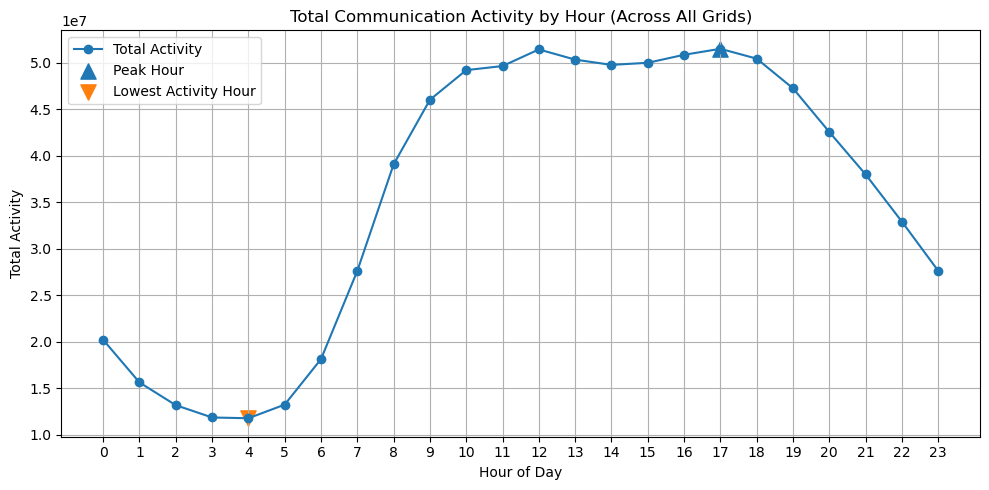

In [784]:

plt.figure(figsize=(10, 5))

# Ploting activity for all hours
plt.plot(
    activity_by_hour.index,
    activity_by_hour.values,
    marker="o",
    label="Total Activity"
)

# Mark peak hour
plt.scatter(
    peak_hour,
    activity_by_hour.loc[peak_hour],
    s=120,
    marker="^",
    label="Peak Hour"
)

# Mark lowest activity hour
plt.scatter(
    lowest_activity_hour,
    activity_by_hour.loc[lowest_activity_hour],
    s=120,
    marker="v",
    label="Lowest Activity Hour"
)

plt.xlabel("Hour of Day")
plt.ylabel("Total Activity")
plt.title("Total Communication Activity by Hour (Across All Grids)")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### The figure presents total communication activity aggregated across all grids for each hour of the day. Activity is lowest during the early morning hours, reaching its minimum at hour 4, when user activity is minimal. Activity then increases steadily throughout the morning and early afternoon, peaking at hour 17, which corresponds to the highest overall level of communication. After this peak, activity gradually declines into the evening and night. This pattern reflects typical daily human communication and internet usage behavior.

## Q5.3 Calculate and report: mean, median, std, min, max for total calls by hour

In [785]:
calls_stats_by_hour = (
    combined_df
    .groupby("hour")["total_calls"]
    .agg(["mean", "median", "std", "min", "max"])
)

calls_stats_by_hour


,mean,median,std,min,max
hour,,,,,
0,10.280157,13.425298,5.279040,0.0002,223.4941
1,9.928661,13.425298,5.129893,0.0000,141.9847
2,9.894713,13.425298,5.329786,0.0000,210.9691
3,9.953373,13.425298,5.649571,0.0000,298.3541
4,10.235666,13.425298,5.294288,0.0000,255.0555
5,10.029019,13.425298,5.395003,0.0000,177.1690
6,10.339697,13.425298,4.969421,0.0002,201.3488
7,11.464472,13.425298,8.435423,0.0000,412.7314
8,13.272816,13.425298,22.237365,0.0000,1122.7091


##### This table summarizes total call activity across all grids for each hour of the day. The mean and median show the typical number of calls per record at each hour, while the standard deviation indicates how much call activity varies across grid cells. The minimum and maximum values highlight the range of call activity observed, showing that some grid areas experience much higher call volumes than others, especially during daytime and early evening hours.

## Q6 What percentage of total activity happens during daytime (6am-8pm) vs nighttime(8 pm -6 am)?

In [786]:
# Daytime (6am–8pm) vs Nighttime (8pm–6am) percentage of total activity

# Defining hour ranges for daytime and nighttime
daytime_hours = list(range(6, 21))                # 6,7,...,20 (includes 8pm hour=20)
nighttime_hours = list(range(21, 24)) + list(range(0, 6))  # 21,22,23,0,1,2,3,4,5


# Sum activity for daytime and nighttime
daytime_activity = activity_by_hour.loc[daytime_hours].sum()
nighttime_activity = activity_by_hour.loc[nighttime_hours].sum()
total_activity = daytime_activity + nighttime_activity

# Compute percentages
daytime_percentage = (daytime_activity / total_activity) * 100
nighttime_percentage = (nighttime_activity / total_activity) * 100

print(f"Daytime (6am–8pm) activity: {daytime_activity:,.2f} ({daytime_percentage:.2f}%)")
print(f"Nighttime (8pm–6am) activity: {nighttime_activity:,.2f} ({nighttime_percentage:.2f}%)")

Daytime (6am–8pm) activity: 673,564,005.90 (78.51%)
Nighttime (8pm–6am) activity: 184,382,270.51 (21.49%)


### The majority of total communication activity occurs during daytime hours (6am–8pm), accounting for `78.51%` of overall activity, while nighttime activity (8pm–6am) represents `21.49%`. This distribution reflects typical daily behavior, with higher communication and internet usage during active daytime hours and reduced activity overnight.

## Q7 Do international calls happen at different times than domestic? (compare hourly patterns)?

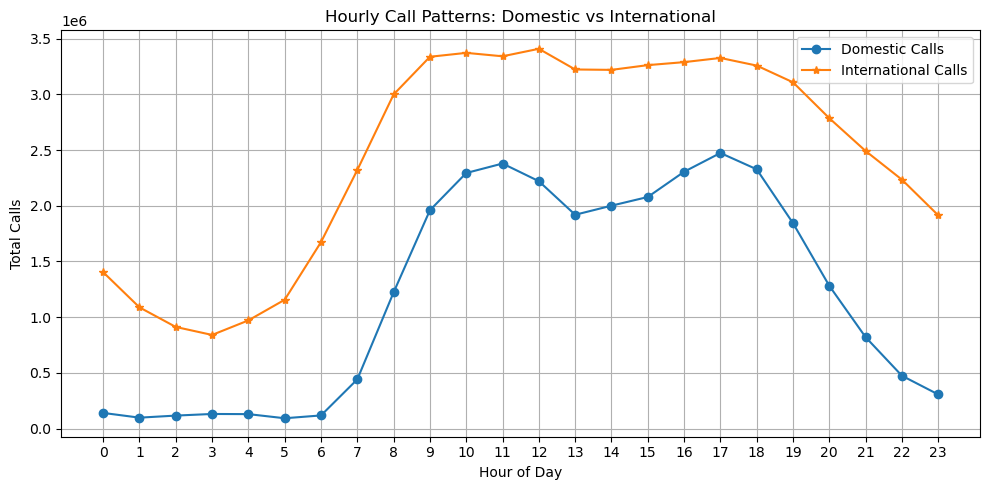

In [787]:


# Split domestic vs international
domestic_calls = combined_df[combined_df["countrycode"] == 39]
international_calls = combined_df[combined_df["countrycode"] != 39]

# Aggregate total calls by hour
domestic_by_hour = domestic_calls.groupby("hour")["total_calls"].sum()
international_by_hour = international_calls.groupby("hour")["total_calls"].sum()

# Plot hourly patterns
plt.figure(figsize=(10, 5))
plt.plot(domestic_by_hour.index, domestic_by_hour.values, label="Domestic Calls", marker="o") 
plt.plot(international_by_hour.index, international_by_hour.values, label="International Calls", marker="*")
plt.xlabel("Hour of Day")
plt.ylabel("Total Calls")
plt.title("Hourly Call Patterns: Domestic vs International")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### From the plot, domestic calls are mostly concentrated during daytime hours. They increase in the morning, reach their highest levels in the afternoon and early evening, and then drop sharply at night. This shows that local calls mainly follow normal daily routines and working hours.

##### International calls follow a different pattern. Although they also increase during the day, they remain relatively high during the evening and late-night hours compared to domestic calls. This means international calls are spread more evenly throughout the day.

##### These differences show that international calls do happen at different times than domestic calls. This is likely because people make international calls to match the time zones of the people they are calling in other countries.

## Q8. Use numpy to perform statistical comparisons between different conditions

In [788]:

# splitting domestic and international data
domestic_df = combined_df[combined_df["countrycode"] == 39].copy()
international_df = combined_df[combined_df["countrycode"] != 39].copy()

# creating total calls and total sms for combined data
combined_df['total_calls'] = combined_df['callin'] + combined_df['callout']
combined_df['total_sms'] = combined_df['smsin'] + combined_df['smsout']

# domestic totals
domestic_df['total_calls'] = domestic_df['callin'] + domestic_df['callout']
domestic_df['total_sms'] = domestic_df['smsin'] + domestic_df['smsout']

# international totals
international_df['total_calls'] = international_df['callin'] + international_df['callout']
international_df['total_sms'] = international_df['smsin'] + international_df['smsout']


## Q8.1 What percentage of calls are international vs domestic(Italy)?

In [789]:
domestic_calls = np.sum(domestic_df['total_calls'].values)
international_calls = np.sum(international_df['total_calls'].values)

total_calls = domestic_calls + international_calls

percentage_domestic_calls = (domestic_calls / total_calls) * 100
percentage_international_calls = (international_calls / total_calls) * 100

print("Percentage of domestic calls: {:.2f}%".format(percentage_domestic_calls))
print("Percentage of international calls: {:.2f}%".format(percentage_international_calls))

Percentage of domestic calls: 33.11%
Percentage of international calls: 66.89%


##### The results show that `66.89%` of total calls are international, while `33.11%` are domestic. This indicates that international calls make up a larger share of overall call activity in the dataset. This is likely because international calls are aggregated across many different country codes, whereas domestic calls include only Italy (country code 39).

## Q8.2 What percentage of SMS are international vs domestic(Italy)?

In [790]:
domestic_sms = np.sum(domestic_df['total_sms'].values)
international_sms = np.sum(international_df['total_sms'].values)

total_sms = domestic_sms + international_sms

percentage_domestic_sms = (domestic_sms / total_sms) * 100
percentage_international_sms = (international_sms / total_sms) * 100

print("Percentage of domestic SMS: {:.2f}%".format(percentage_domestic_sms))
print("Percentage of international SMS: {:.2f}%".format(percentage_international_sms))

Percentage of domestic SMS: 24.98%
Percentage of international SMS: 75.02%


##### The results show that `75.02%` of SMS messages are international, while `24.98%` are domestic. This means most SMS activity in the dataset involves international communication. Similar to calls, this is likely because international SMS traffic is combined across many different country codes, while domestic SMS only includes messages within Italy.

## Q8.3 Are international calls more incoming or outgoing?

In [791]:
international_incoming_calls = np.sum(international_df['callin'].values)
internation_outgoing_calls = np.sum(international_df['callout'].values)

incoming_outgoing_calls_ratio = international_incoming_calls/internation_outgoing_calls

print("International calls ratio: {:.2f}".format(incoming_outgoing_calls_ratio))

International calls ratio: 1.67


##### An incoming-to-outgoing ratio of `1.67` indicates that Italy receives more international calls than it places. This suggests that, during the observed period, international communication is more often initiated from abroad toward users in Italy

## Q8.4 is there a correlation between SMS and call volume at grid level?

In [792]:
# aggregate sms and calls by CellID
grid_activity = combined_df.groupby('CellID').agg({
    'total_calls': 'sum',
    'total_sms': 'sum'})
# computeing peason correlation 
correlation = np.corrcoef(grid_activity['total_calls'], grid_activity['total_sms'])[0, 1]
print("Correlation between SMS and call volume at grid level: {:.2f}".format(correlation))

Correlation between SMS and call volume at grid level: 0.99


##### The correlation between SMS volume and call volume at the grid level is `0.99`, which indicates a very strong positive relationship. This means that grid areas with high SMS activity also tend to have high call activity. In other words, places where people send more messages are usually the same places where they make more calls.

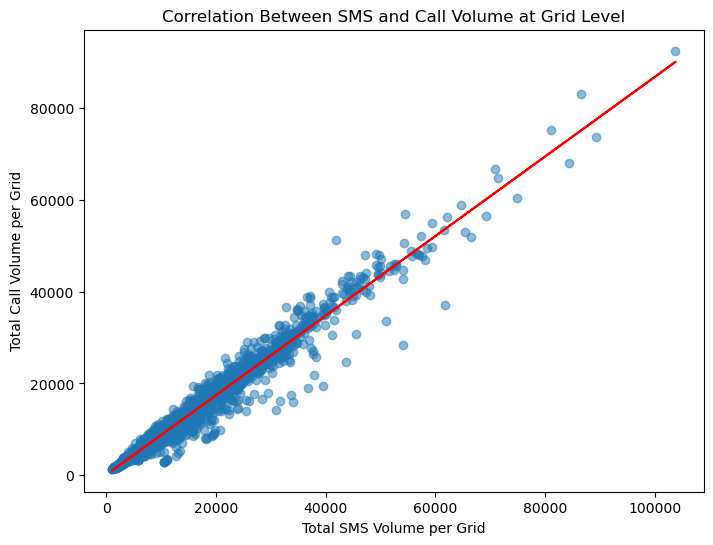

In [793]:

# Scatter plot for SMS vs Calls at grid level
plt.figure(figsize=(8, 6))
plt.scatter(
    grid_activity["total_sms"],
    grid_activity["total_calls"],
    alpha=0.5
)

# Add best-fit (regression) line
m, b = np.polyfit(
    grid_activity["total_sms"],
    grid_activity["total_calls"],
    1

)
plt.plot(
    grid_activity["total_sms"],
    m * grid_activity["total_sms"] + b,
    color="red"

)

plt.xlabel("Total SMS Volume per Grid")
plt.ylabel("Total Call Volume per Grid")
plt.title("Correlation Between SMS and Call Volume at Grid Level")
# plt.grid(True)

plt.show()


##### The scatter plot shows a strong positive linear relationship between SMS volume and call volume across grid cells. Each point represents a grid, and grids with higher SMS activity also tend to have higher call activity. The fitted line closely follows the data points, confirming the very high correlation value observed earlier. This indicates that areas with intense messaging activity are also areas with high calling activity, reflecting similar communication behavior across grids.